# 📊 Análisis Espectral de Señales EMG - HeClaMoSTC

## Objetivos:
1. **Análisis espectral** completo de señales EMG sin filtrar
2. **Consistencia** entre repeticiones del mismo movimiento
3. **Diferencias espectrales** entre movimientos Risk y Safe

## Estructura:
- 40 sujetos
- 17 movimientos (1-17, excluyendo descanso)
- 6 repeticiones por movimiento
- 12 canales EMG:
  - CH1-8: Electrodes equally spaced around forearm (radiohumeral joint)
  - CH9: Flexor Digitorum Superficialis
  - CH10: Extensor Digitorum Superficialis
  - CH11: Biceps Brachii
  - CH12: Triceps Brachii
- Frecuencia de muestreo: 2000 Hz

## Clasificación:
- **Risk**: Movimientos 13 (Wrist flexion), 14 (Wrist extension), 15 (Wrist radial deviation), 16 (Wrist ulnar deviation)
- **Safe**: Movimientos 1-12, 17

In [ ]:
# ============================================================================
# 📦 INSTALACIÓN Y SETUP
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.fft import fft, fftfreq
from tqdm import tqdm

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("✅ Setup completado")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup completado


In [ ]:
# ============================================================================
# ⚙️ CONFIGURACIÓN
# ============================================================================

class Config:
    # Rutas
    BASE_DIR = Path('/content/drive/MyDrive')
    DATA_DIR = BASE_DIR / 'DB2_E1_only' / 'train'

    # Parámetros de señal
    FS = 2000  # Hz
    N_CHANNELS = 12
    N_SUBJECTS = 40
    N_MOVEMENTS = 17
    N_REPETITIONS = 6

    # Clasificación
    RISK_MOVEMENTS = [13, 14, 15, 16]
    SAFE_MOVEMENTS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17]

    # Análisis espectral
    FREQ_BANDS = {
        'Very Low': (0, 20),
        'Low': (20, 100),
        'Mid': (100, 200),
        'High': (200, 400),
        'Very High': (400, 500)
    }

    # Nombres de canales
    # CH1-8: Forearm electrodes (equally spaced around forearm at radiohumeral joint)
    # CH9: Flexor Digitorum Superficialis, CH10: Extensor Digitorum Superficialis
    # CH11: Biceps Brachii, CH12: Triceps Brachii
    CHANNEL_NAMES = [
        'CH1_Forearm', 'CH2_Forearm', 'CH3_Forearm', 'CH4_Forearm',
        'CH5_Forearm', 'CH6_Forearm', 'CH7_Forearm', 'CH8_Forearm',
        'CH9_FlexorDigit', 'CH10_ExtensorDigit', 'CH11_Biceps', 'CH12_Triceps'
    ]

    # Nombres de movimientos (Exercise B - DB2)
    MOVEMENT_NAMES = {
        1: 'Thumb up',
        2: 'Extension of index, middle, flexion of the others',
        3: 'Flexion of ring and little finger, extension of the others',
        4: 'Thumb opposing base of little finger',
        5: 'Abduction of all fingers',
        6: 'Fingers flexed together in fist',
        7: 'Pointing index',
        8: 'Adduction of extended fingers',
        9: 'Wrist supination (axis: middle finger)',
        10: 'Wrist pronation (axis: middle finger)',
        11: 'Wrist supination (axis: little finger)',
        12: 'Wrist pronation (axis: little finger)',
        13: 'Wrist flexion',
        14: 'Wrist extension',
        15: 'Wrist radial deviation',
        16: 'Wrist ulnar deviation',
        17: 'Wrist extension with closed hand'
    }

cfg = Config()
print(f"✅ Configuración cargada")
print(f"   Data dir: {cfg.DATA_DIR}")
print(f"   Risk movements: {cfg.RISK_MOVEMENTS}")
print(f"   Safe movements: {cfg.SAFE_MOVEMENTS}")

✅ Configuración cargada
   Data dir: /content/drive/MyDrive/DB2_E1_only/train
   Risk movements: [13, 14, 15, 16]
   Safe movements: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17]


In [ ]:
# ============================================================================
# 📂 CARGA DE DATOS SIN FILTRAR
# ============================================================================

def load_raw_data(cfg):
    """
    Carga todas las señales EMG SIN FILTRAR
    Excluye descanso (stimulus == 0)
    """
    mat_files = sorted(cfg.DATA_DIR.glob('S*.mat'))

    if len(mat_files) == 0:
        raise ValueError(f"❌ No se encontraron archivos en {cfg.DATA_DIR}")

    print(f"\n📂 Cargando {len(mat_files)} sujetos (señales RAW sin filtrar)...")

    data_dict = {}

    for mat_file in tqdm(mat_files, desc="Cargando sujetos"):
        subj_id = mat_file.stem.split('_')[0]  # 'S1', 'S2', etc.

        # Cargar archivo .mat
        mat_data = loadmat(mat_file)
        emg_raw = mat_data['emg'].astype(np.float32)
        stimulus = mat_data['restimulus'].flatten()
        repetition = mat_data['rerepetition'].flatten()

        # EXCLUIR DESCANSO (stimulus == 0)
        mask_no_rest = stimulus != 0

        data_dict[subj_id] = {
            'emg': emg_raw[mask_no_rest],
            'stimulus': stimulus[mask_no_rest],
            'repetition': repetition[mask_no_rest]
        }

    print(f"✅ {len(data_dict)} sujetos cargados")
    return data_dict

# Cargar datos
data_dict = load_raw_data(cfg)

# Verificar primer sujeto
first_subj = list(data_dict.keys())[0]
print(f"\n📊 Ejemplo - {first_subj}:")
print(f"   EMG shape: {data_dict[first_subj]['emg'].shape}")
print(f"   Movements: {np.unique(data_dict[first_subj]['stimulus'])}")
print(f"   Repetitions: {np.unique(data_dict[first_subj]['repetition'])}")


📂 Cargando 40 sujetos (señales RAW sin filtrar)...


Cargando sujetos: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

✅ 40 sujetos cargados

📊 Ejemplo - S10:
   EMG shape: (816373, 12)
   Movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
   Repetitions: [1 2 3 4 5 6]


In [ ]:
# ============================================================================
# 🔧 FUNCIONES DE ANÁLISIS TEMPORAL
# ============================================================================

def compute_temporal_features(signal_segment):
    """
    Calcula features en el dominio del tiempo para un segmento de señal

    Args:
        signal_segment: numpy array de forma (n_samples, n_channels)

    Returns:
        dict con features temporales
    """
    features = {}

    # Estadísticos básicos
    features['mean'] = np.mean(signal_segment, axis=0)
    features['std'] = np.std(signal_segment, axis=0)
    features['var'] = np.var(signal_segment, axis=0)
    features['min'] = np.min(signal_segment, axis=0)
    features['max'] = np.max(signal_segment, axis=0)
    features['range'] = features['max'] - features['min']

    # RMS (Root Mean Square)
    features['rms'] = np.sqrt(np.mean(signal_segment**2, axis=0))

    # MAV (Mean Absolute Value)
    features['mav'] = np.mean(np.abs(signal_segment), axis=0)

    # Energía de la señal
    features['energy'] = np.sum(signal_segment**2, axis=0)

    # Factor de forma (Shape factor)
    features['shape_factor'] = features['rms'] / features['mav']

    # Factor de cresta (Crest factor)
    features['crest_factor'] = features['max'] / features['rms']

    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal_segment), axis=0) != 0, axis=0)
    features['zero_crossings'] = zc

    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal_segment, axis=0)
    ssc = np.sum(np.diff(np.sign(diff_signal), axis=0) != 0, axis=0)
    features['slope_changes'] = ssc

    return features

print("✅ Funciones de análisis temporal definidas")

✅ Funciones de análisis temporal definidas


In [ ]:
# ============================================================================
# 📊 FUNCIONES DE ANÁLISIS ESPECTRAL
# ============================================================================

def compute_fft_spectrum(signal_segment, fs=2000):
    """
    Calcula el espectro FFT para cada canal

    Args:
        signal_segment: numpy array (n_samples, n_channels)
        fs: frecuencia de muestreo

    Returns:
        freqs: array de frecuencias
        magnitude: magnitud del espectro para cada canal
        power: densidad espectral de potencia
    """
    n_samples = signal_segment.shape[0]
    n_channels = signal_segment.shape[1]

    # FFT
    fft_vals = fft(signal_segment, axis=0)

    # Solo frecuencias positivas
    n_freqs = n_samples // 2
    freqs = fftfreq(n_samples, 1/fs)[:n_freqs]

    # Magnitud y potencia
    magnitude = np.abs(fft_vals[:n_freqs]) / n_samples
    power = magnitude ** 2

    return freqs, magnitude, power


def compute_spectral_features(freqs, power, freq_bands):
    """
    Calcula features espectrales por bandas de frecuencia

    Args:
        freqs: array de frecuencias
        power: densidad espectral de potencia (n_freqs, n_channels)
        freq_bands: diccionario de bandas {nombre: (f_low, f_high)}

    Returns:
        dict con features espectrales
    """
    features = {}

    # Energía total
    features['total_power'] = np.sum(power, axis=0)

    # Frecuencia dominante (pico)
    peak_idx = np.argmax(power, axis=0)
    features['peak_frequency'] = freqs[peak_idx]
    features['peak_power'] = np.max(power, axis=0)

    # Frecuencia media (MNF - Mean Frequency)
    features['mean_frequency'] = np.sum(freqs[:, np.newaxis] * power, axis=0) / features['total_power']

    # Frecuencia mediana (MDF - Median Frequency)
    cumsum_power = np.cumsum(power, axis=0)
    half_power = features['total_power'] / 2
    median_idx = np.argmax(cumsum_power >= half_power, axis=0)
    features['median_frequency'] = freqs[median_idx]

    # Energía por bandas
    features['band_power'] = {}
    features['band_power_ratio'] = {}

    for band_name, (f_low, f_high) in freq_bands.items():
        mask = (freqs >= f_low) & (freqs <= f_high)
        band_power = np.sum(power[mask], axis=0)
        features['band_power'][band_name] = band_power
        features['band_power_ratio'][band_name] = band_power / features['total_power']

    # Ancho de banda (frecuencia que contiene el 95% de la potencia)
    power_95 = 0.95 * features['total_power']
    bandwidth_idx = np.argmax(cumsum_power >= power_95, axis=0)
    features['bandwidth_95'] = freqs[bandwidth_idx]

    return features


def compute_spectrogram(signal_segment, fs=2000, window_size=256, overlap=128):
    """
    Calcula espectrograma para un canal

    Args:
        signal_segment: señal de un canal (n_samples,)
        fs: frecuencia de muestreo
        window_size: tamaño de ventana para STFT
        overlap: solapamiento entre ventanas

    Returns:
        f: frecuencias
        t: tiempos
        Sxx: espectrograma
    """
    f, t, Sxx = signal.spectrogram(
        signal_segment,
        fs=fs,
        window='hann',
        nperseg=window_size,
        noverlap=overlap
    )
    return f, t, Sxx

print("✅ Funciones de análisis espectral definidas")

✅ Funciones de análisis espectral definidas


In [ ]:
# ============================================================================
# 🔄 FUNCIONES DE CONSISTENCIA ENTRE REPETICIONES
# ============================================================================

def compute_repetition_consistency(data_dict, subject, movement, cfg):
    """
    Calcula métricas de consistencia entre repeticiones de un movimiento

    Returns:
        dict con métricas de consistencia espectral y temporal
    """
    emg = data_dict[subject]['emg']
    stimulus = data_dict[subject]['stimulus']
    repetition = data_dict[subject]['repetition']

    # Extraer todas las repeticiones del movimiento
    mask_mov = stimulus == movement

    repetitions_data = {}
    spectral_features = {}
    temporal_features = {}

    for rep in range(1, cfg.N_REPETITIONS + 1):
        mask_rep = mask_mov & (repetition == rep)
        if np.sum(mask_rep) > 0:
            rep_data = emg[mask_rep]
            repetitions_data[rep] = rep_data

            # Features temporales
            temporal_features[rep] = compute_temporal_features(rep_data)

            # Features espectrales
            freqs, magnitude, power = compute_fft_spectrum(rep_data, cfg.FS)
            spectral_features[rep] = {
                'freqs': freqs,
                'magnitude': magnitude,
                'power': power,
                'features': compute_spectral_features(freqs, power, cfg.FREQ_BANDS)
            }

    # Calcular correlaciones espectrales entre repeticiones
    correlations = {}
    reps = list(spectral_features.keys())

    # Crear grid de frecuencias común para interpolación
    freq_common = np.linspace(0, 500, 1000)

    for i, rep1 in enumerate(reps):
        for rep2 in reps[i+1:]:
            # Obtener espectros originales
            freqs1 = spectral_features[rep1]['freqs']
            freqs2 = spectral_features[rep2]['freqs']
            spectrum1 = np.mean(spectral_features[rep1]['power'], axis=1)
            spectrum2 = np.mean(spectral_features[rep2]['power'], axis=1)

            # Interpolar ambos espectros al grid común
            spectrum1_interp = np.interp(freq_common, freqs1, spectrum1)
            spectrum2_interp = np.interp(freq_common, freqs2, spectrum2)

            # Ahora calcular correlación
            corr, _ = pearsonr(spectrum1_interp, spectrum2_interp)
            correlations[f"{rep1}-{rep2}"] = corr

    # Consistencia temporal: CV (Coeficiente de Variación) de RMS
    rms_values = np.array([temporal_features[rep]['rms'] for rep in reps])
    cv_rms = np.std(rms_values, axis=0) / np.mean(rms_values, axis=0)

    # Consistencia espectral: CV de frecuencia dominante
    peak_freqs = np.array([spectral_features[rep]['features']['peak_frequency'] for rep in reps])
    cv_peak_freq = np.std(peak_freqs, axis=0) / np.mean(peak_freqs, axis=0)

    consistency = {
        'spectral_correlations': correlations,
        'mean_spectral_correlation': np.mean(list(correlations.values())),
        'cv_rms': cv_rms,
        'mean_cv_rms': np.mean(cv_rms),
        'cv_peak_frequency': cv_peak_freq,
        'mean_cv_peak_frequency': np.mean(cv_peak_freq)
    }

    return {
        'spectral_features': spectral_features,
        'temporal_features': temporal_features,
        'consistency': consistency
    }

print("✅ Funciones de consistencia definidas")

✅ Funciones de consistencia definidas


In [ ]:
# ============================================================================
# 📈 VISUALIZACIÓN: ESPECTROS POR MOVIMIENTO Y REPETICIÓN
# ============================================================================

def plot_movement_spectra(data_dict, subject, movement, cfg, channel=0):
    """
    Plotea espectros de potencia de todas las repeticiones de un movimiento
    """
    emg = data_dict[subject]['emg']
    stimulus = data_dict[subject]['stimulus']
    repetition = data_dict[subject]['repetition']

    mask_mov = stimulus == movement

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    category = 'RISK' if movement in cfg.RISK_MOVEMENTS else 'SAFE'
    mov_name = cfg.MOVEMENT_NAMES.get(movement, f"Mov {movement}")

    fig.suptitle(
        f'{subject} - Movement {movement} [{category}]: {mov_name}\n'
        f'Channel: {cfg.CHANNEL_NAMES[channel]}',
        fontsize=14, fontweight='bold'
    )

    for rep_idx, rep in enumerate(range(1, 7)):
        ax = axes[rep_idx]

        mask_rep = mask_mov & (repetition == rep)

        if np.sum(mask_rep) > 0:
            rep_data = emg[mask_rep, channel]

            # Calcular FFT
            freqs, magnitude, power = compute_fft_spectrum(rep_data[:, np.newaxis], cfg.FS)

            # Plot espectro
            ax.plot(freqs, power[:, 0], linewidth=1.5, alpha=0.8)
            ax.set_xlim(0, 500)
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power')
            ax.set_title(f'Repetition {rep}')
            ax.grid(True, alpha=0.3)

            # Marcar frecuencia dominante
            peak_idx = np.argmax(power[:, 0])
            peak_freq = freqs[peak_idx]
            ax.axvline(peak_freq, color='red', linestyle='--', alpha=0.5, label=f'Peak: {peak_freq:.1f} Hz')
            ax.legend(fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Repetition {rep}')

    plt.tight_layout()
    return fig


def plot_all_movements_subject(data_dict, subject, repetition, cfg, channel=0):
    """
    Plotea espectros de los 17 movimientos para una repetición específica
    """
    emg = data_dict[subject]['emg']
    stimulus = data_dict[subject]['stimulus']
    rep_labels = data_dict[subject]['repetition']

    fig, axes = plt.subplots(4, 5, figsize=(20, 12))
    axes = axes.flatten()

    fig.suptitle(
        f'{subject} - All Movements - Repetition {repetition}\n'
        f'Channel: {cfg.CHANNEL_NAMES[channel]}',
        fontsize=16, fontweight='bold'
    )

    for mov_idx, movement in enumerate(range(1, 18)):
        ax = axes[mov_idx]

        mask = (stimulus == movement) & (rep_labels == repetition)

        if np.sum(mask) > 0:
            mov_data = emg[mask, channel]

            # FFT
            freqs, magnitude, power = compute_fft_spectrum(mov_data[:, np.newaxis], cfg.FS)

            # Color según categoría
            color = 'red' if movement in cfg.RISK_MOVEMENTS else 'blue'
            category = 'RISK' if movement in cfg.RISK_MOVEMENTS else 'SAFE'

            ax.plot(freqs, power[:, 0], color=color, linewidth=1.2, alpha=0.8)
            ax.set_xlim(0, 500)
            ax.set_title(f'M{movement} [{category}]', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)

            if mov_idx >= 15:  # Solo bottom row
                ax.set_xlabel('Freq (Hz)', fontsize=8)
            if mov_idx % 5 == 0:  # Solo left column
                ax.set_ylabel('Power', fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Movement {movement}', fontsize=10)

    # Ocultar ejes extra
    for i in range(17, 20):
        axes[i].axis('off')

    plt.tight_layout()
    return fig

print("✅ Funciones de visualización definidas")

✅ Funciones de visualización definidas


In [ ]:
# ============================================================================
# 📊 COMPARACIÓN RISK vs SAFE
# ============================================================================

def compare_risk_vs_safe_spectra(data_dict, subject, repetition, cfg):
    """
    Compara características espectrales entre movimientos Risk y Safe
    """
    emg = data_dict[subject]['emg']
    stimulus = data_dict[subject]['stimulus']
    rep_labels = data_dict[subject]['repetition']

    # Máscaras
    mask_rep = rep_labels == repetition
    mask_risk = np.isin(stimulus, cfg.RISK_MOVEMENTS) & mask_rep
    mask_safe = np.isin(stimulus, cfg.SAFE_MOVEMENTS) & mask_rep

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    fig.suptitle(
        f'{subject} - RISK vs SAFE Comparison - Repetition {repetition}',
        fontsize=14, fontweight='bold'
    )

    # Promediar sobre varios canales representativos
    selected_channels = [0, 4, 8]  # FDS, ED, FPL

    risk_spectra = []
    safe_spectra = []

    for ch in selected_channels:
        if np.sum(mask_risk) > 0:
            risk_data = emg[mask_risk, ch]
            freqs_r, _, power_r = compute_fft_spectrum(risk_data[:, np.newaxis], cfg.FS)
            risk_spectra.append(power_r[:, 0])

        if np.sum(mask_safe) > 0:
            safe_data = emg[mask_safe, ch]
            freqs_s, _, power_s = compute_fft_spectrum(safe_data[:, np.newaxis], cfg.FS)
            safe_spectra.append(power_s[:, 0])

    # Promedios
    risk_avg = np.mean(risk_spectra, axis=0) if len(risk_spectra) > 0 else None
    safe_avg = np.mean(safe_spectra, axis=0) if len(safe_spectra) > 0 else None

    # 1. Espectros superpuestos
    ax = axes[0, 0]
    if risk_avg is not None:
        ax.plot(freqs_r, risk_avg, 'r-', linewidth=2, label='RISK', alpha=0.8)
    if safe_avg is not None:
        ax.plot(freqs_s, safe_avg, 'b-', linewidth=2, label='SAFE', alpha=0.8)
    ax.set_xlim(0, 500)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Average Power')
    ax.set_title('Average Power Spectrum')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Espectros en escala log
    ax = axes[0, 1]
    if risk_avg is not None:
        ax.semilogy(freqs_r, risk_avg, 'r-', linewidth=2, label='RISK', alpha=0.8)
    if safe_avg is not None:
        ax.semilogy(freqs_s, safe_avg, 'b-', linewidth=2, label='SAFE', alpha=0.8)
    ax.set_xlim(0, 500)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (log scale)')
    ax.set_title('Power Spectrum (Log Scale)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Distribución por bandas
    ax = axes[0, 2]
    if risk_avg is not None and safe_avg is not None:
        band_names = list(cfg.FREQ_BANDS.keys())
        risk_band_power = []
        safe_band_power = []

        # CORRECCIÓN en la sección 3 (líneas ~78-83)
        for band_name, (f_low, f_high) in cfg.FREQ_BANDS.items():
            # Máscara para RISK
            mask_band_r = (freqs_r >= f_low) & (freqs_r <= f_high)
            risk_band_power.append(np.sum(risk_avg[mask_band_r]))

            # Máscara para SAFE
            mask_band_s = (freqs_s >= f_low) & (freqs_s <= f_high)
            safe_band_power.append(np.sum(safe_avg[mask_band_s]))

        x = np.arange(len(band_names))
        width = 0.35
        ax.bar(x - width/2, risk_band_power, width, label='RISK', color='red', alpha=0.7)
        ax.bar(x + width/2, safe_band_power, width, label='SAFE', color='blue', alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(band_names, rotation=45)
        ax.set_ylabel('Band Power')
        ax.set_title('Power by Frequency Band')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

    # 4. Diferencia espectral
    ax = axes[1, 0]
    if risk_avg is not None and safe_avg is not None:
        # Crear grid de frecuencias común
        freq_common = np.linspace(0, 500, 1000)  # 1000 puntos de 0 a 500 Hz

        # Interpolar ambos espectros al grid común
        risk_interp = np.interp(freq_common, freqs_r, risk_avg)
        safe_interp = np.interp(freq_common, freqs_s, safe_avg)

        # Ahora sí se pueden restar
        diff = risk_interp - safe_interp

        ax.plot(freq_common, diff, 'k-', linewidth=2)
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.fill_between(freq_common, 0, diff, where=(diff > 0), color='red', alpha=0.3, label='Risk > Safe')
        ax.fill_between(freq_common, 0, diff, where=(diff < 0), color='blue', alpha=0.3, label='Safe > Risk')
        ax.set_xlim(0, 500)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power Difference (Risk - Safe)')
        ax.set_title('Spectral Difference')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 5. Ratio de potencia por bandas
    ax = axes[1, 1]
    if risk_avg is not None and safe_avg is not None:
        risk_total = np.sum(risk_avg)
        safe_total = np.sum(safe_avg)

        risk_ratios = []
        safe_ratios = []

        # CORRECCIÓN en la sección 5
        for band_name, (f_low, f_high) in cfg.FREQ_BANDS.items():
            mask_band_r = (freqs_r >= f_low) & (freqs_r <= f_high)
            risk_ratios.append(np.sum(risk_avg[mask_band_r]) / risk_total * 100)

            mask_band_s = (freqs_s >= f_low) & (freqs_s <= f_high)
            safe_ratios.append(np.sum(safe_avg[mask_band_s]) / safe_total * 100)

        x = np.arange(len(band_names))
        width = 0.35
        ax.bar(x - width/2, risk_ratios, width, label='RISK', color='red', alpha=0.7)
        ax.bar(x + width/2, safe_ratios, width, label='SAFE', color='blue', alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(band_names, rotation=45)
        ax.set_ylabel('Power Ratio (%)')
        ax.set_title('Relative Power by Band')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

    # 6. Estadísticas espectrales
    ax = axes[1, 2]
    ax.axis('off')

    if risk_avg is not None and safe_avg is not None:
        # Calcular estadísticas
        risk_peak_idx = np.argmax(risk_avg)
        safe_peak_idx = np.argmax(safe_avg)

        stats_text = f"""SPECTRAL STATISTICS

RISK Movements:
  • Peak Frequency: {freqs_r[risk_peak_idx]:.2f} Hz
  • Total Power: {np.sum(risk_avg):.2e}
  • Mean Frequency: {np.sum(freqs_r * risk_avg) / np.sum(risk_avg):.2f} Hz

SAFE Movements:
  • Peak Frequency: {freqs_s[safe_peak_idx]:.2f} Hz
  • Total Power: {np.sum(safe_avg):.2e}
  • Mean Frequency: {np.sum(freqs_s * safe_avg) / np.sum(safe_avg):.2f} Hz

DIFFERENCES:
  • Peak Freq Δ: {abs(freqs_r[risk_peak_idx] - freqs_s[safe_peak_idx]):.2f} Hz
  • Power Ratio: {np.sum(risk_avg) / np.sum(safe_avg):.3f}
        """

        ax.text(0.1, 0.9, stats_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
                fontfamily='monospace')

    plt.tight_layout()
    return fig

print("✅ Funciones de comparación Risk vs Safe definidas")

✅ Funciones de comparación Risk vs Safe definidas


In [ ]:
# ============================================================================
# 📉 ANÁLISIS DE CONSISTENCIA ENTRE REPETICIONES
# ============================================================================

def plot_repetition_consistency(data_dict, subject, movement, cfg):
    """
    Visualiza consistencia espectral entre repeticiones
    """
    result = compute_repetition_consistency(data_dict, subject, movement, cfg)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    category = 'RISK' if movement in cfg.RISK_MOVEMENTS else 'SAFE'
    mov_name = cfg.MOVEMENT_NAMES.get(movement, f"Mov {movement}")

    fig.suptitle(
        f'{subject} - Movement {movement} [{category}]: {mov_name}\n'
        f'Repetition Consistency Analysis',
        fontsize=14, fontweight='bold'
    )

    spectral_features = result['spectral_features']
    consistency = result['consistency']

    # 1. Espectros superpuestos de todas las repeticiones
    ax = axes[0, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, 6))
    for i, (rep, data) in enumerate(spectral_features.items()):
        # Promedio sobre canales
        avg_power = np.mean(data['power'], axis=1)
        ax.plot(data['freqs'], avg_power, color=colors[i], linewidth=1.5,
                label=f'Rep {rep}', alpha=0.7)
    ax.set_xlim(0, 500)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Average Power (all channels)')
    ax.set_title('Overlaid Power Spectra')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Mapa de calor de correlaciones espectrales
    ax = axes[0, 1]
    reps = list(spectral_features.keys())
    n_reps = len(reps)
    corr_matrix = np.ones((n_reps, n_reps))

    for i, rep1 in enumerate(reps):
        for j, rep2 in enumerate(reps):
            if i < j:
                key = f"{rep1}-{rep2}"
                if key in consistency['spectral_correlations']:
                    corr = consistency['spectral_correlations'][key]
                    corr_matrix[i, j] = corr
                    corr_matrix[j, i] = corr

    im = ax.imshow(corr_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
    ax.set_xticks(range(n_reps))
    ax.set_yticks(range(n_reps))
    ax.set_xticklabels([f'R{r}' for r in reps])
    ax.set_yticklabels([f'R{r}' for r in reps])
    ax.set_title('Spectral Correlation Matrix')
    plt.colorbar(im, ax=ax)

    # Añadir valores en las celdas
    for i in range(n_reps):
        for j in range(n_reps):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)

    # 3. Frecuencia dominante por repetición
    ax = axes[0, 2]
    peak_freqs_per_rep = []
    for rep in reps:
        peak_freqs = spectral_features[rep]['features']['peak_frequency']
        peak_freqs_per_rep.append(peak_freqs)

    peak_freqs_per_rep = np.array(peak_freqs_per_rep)  # (n_reps, n_channels)

    for ch in range(cfg.N_CHANNELS):
        ax.plot(reps, peak_freqs_per_rep[:, ch], marker='o', label=cfg.CHANNEL_NAMES[ch],
                linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Repetition')
    ax.set_ylabel('Peak Frequency (Hz)')
    ax.set_title('Peak Frequency Consistency')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    ax.grid(True, alpha=0.3)

    # 4. Potencia total por repetición
    ax = axes[1, 0]
    total_power_per_rep = []
    for rep in reps:
        total_power = spectral_features[rep]['features']['total_power']
        total_power_per_rep.append(total_power)

    total_power_per_rep = np.array(total_power_per_rep)

    for ch in range(cfg.N_CHANNELS):
        ax.plot(reps, total_power_per_rep[:, ch], marker='o', label=cfg.CHANNEL_NAMES[ch],
                linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Repetition')
    ax.set_ylabel('Total Power')
    ax.set_title('Total Power Consistency')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    ax.grid(True, alpha=0.3)

    # 5. Coeficiente de Variación (CV)
    ax = axes[1, 1]
    cv_data = {
        'RMS': consistency['cv_rms'],
        'Peak Freq': consistency['cv_peak_frequency']
    }

    x_pos = np.arange(cfg.N_CHANNELS)
    width = 0.35

    ax.bar(x_pos - width/2, cv_data['RMS'], width, label='CV(RMS)', alpha=0.7)
    ax.bar(x_pos + width/2, cv_data['Peak Freq'], width, label='CV(Peak Freq)', alpha=0.7)

    ax.set_xlabel('Channel')
    ax.set_ylabel('Coefficient of Variation')
    ax.set_title('Temporal & Spectral Variability')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'CH{i+1}' for i in range(cfg.N_CHANNELS)], rotation=45, fontsize=8)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # 6. Estadísticas de consistencia
    ax = axes[1, 2]
    ax.axis('off')

    stats_text = f"""CONSISTENCY METRICS

Spectral Consistency:
  • Mean Correlation: {consistency['mean_spectral_correlation']:.4f}
  • Min Correlation: {min(consistency['spectral_correlations'].values()):.4f}
  • Max Correlation: {max(consistency['spectral_correlations'].values()):.4f}

Temporal Consistency:
  • Mean CV(RMS): {consistency['mean_cv_rms']:.4f}
  • Max CV(RMS): {np.max(consistency['cv_rms']):.4f}

Frequency Consistency:
  • Mean CV(Peak Freq): {consistency['mean_cv_peak_frequency']:.4f}
  • Max CV(Peak Freq): {np.max(consistency['cv_peak_frequency']):.4f}

Interpretation:
  • Correlation > 0.9: Excellent consistency
  • CV < 0.2: Low variability
  • CV > 0.5: High variability
    """

    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
            fontfamily='monospace')

    plt.tight_layout()
    return fig

print("✅ Funciones de análisis de consistencia definidas")

✅ Funciones de análisis de consistencia definidas


---
# 🎯 ANÁLISIS INTERACTIVO

A partir de aquí puedes ejecutar los análisis que necesites

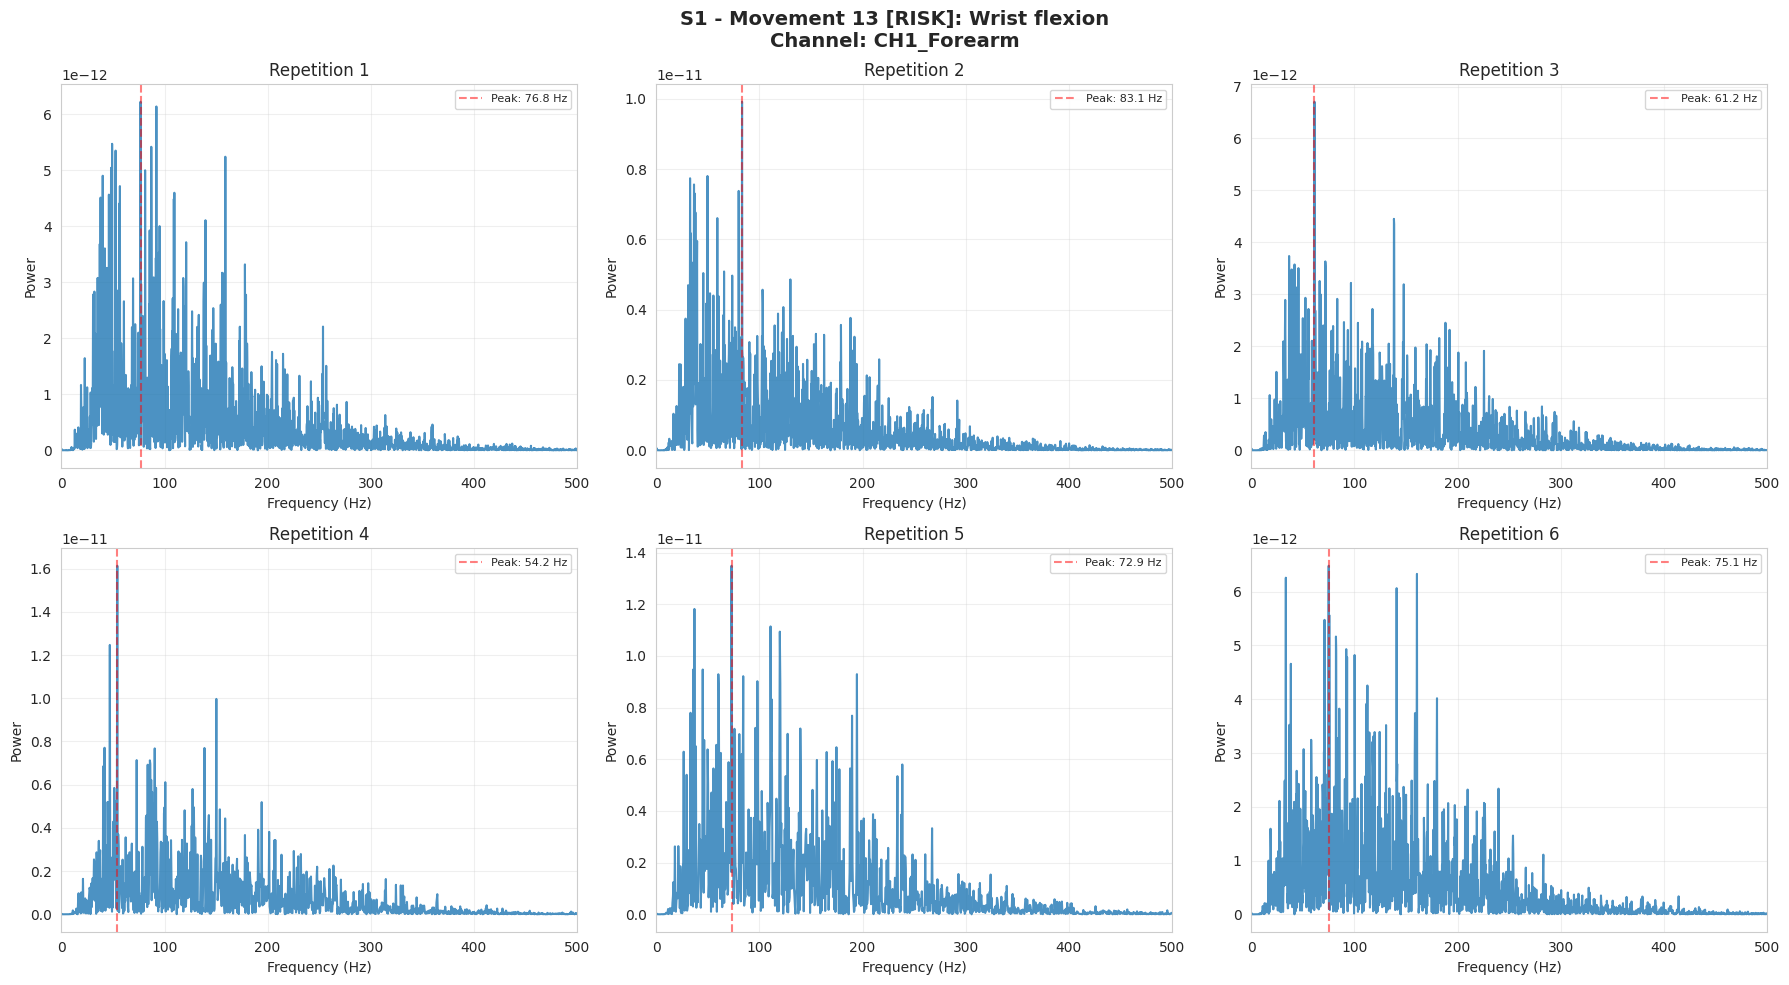

In [ ]:
# ============================================================================
# EJEMPLO 1: Espectros de un movimiento específico (todas las repeticiones)
# ============================================================================

# Configuración
SUBJECT = 'S1'
MOVEMENT = 13  # Movimiento a analizar (1-17)
CHANNEL = 0    # Canal a visualizar (0-11)

fig = plot_movement_spectra(data_dict, SUBJECT, MOVEMENT, cfg, channel=CHANNEL)
plt.show()

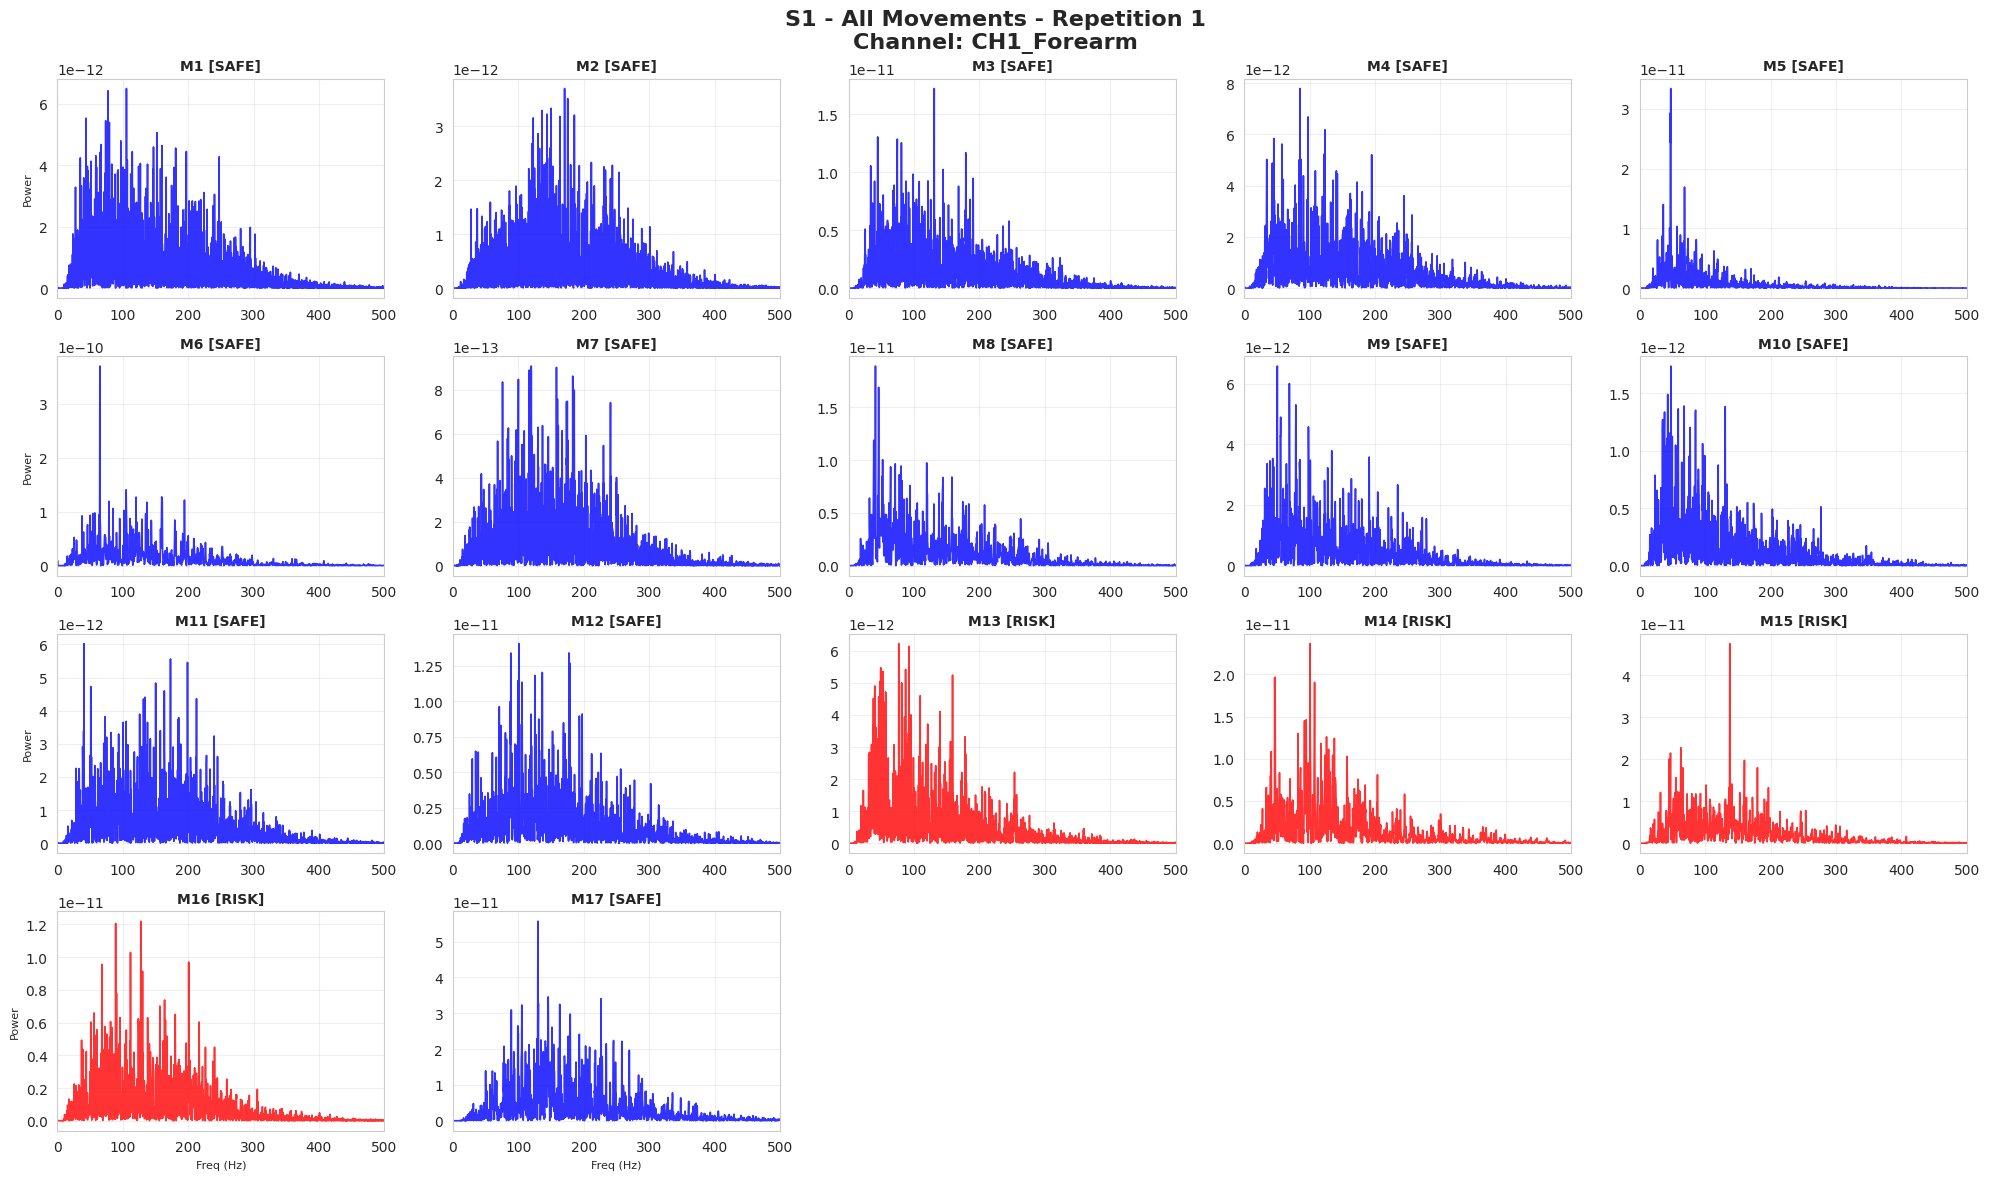

In [ ]:
# ============================================================================
# EJEMPLO 2: Todos los movimientos de un sujeto (repetición específica)
# ============================================================================

# Configuración
SUBJECT = 'S1'
REPETITION = 1  # Repetición a visualizar (1-6)
CHANNEL = 0     # Canal a visualizar (0-11)

fig = plot_all_movements_subject(data_dict, SUBJECT, REPETITION, cfg, channel=CHANNEL)
plt.show()

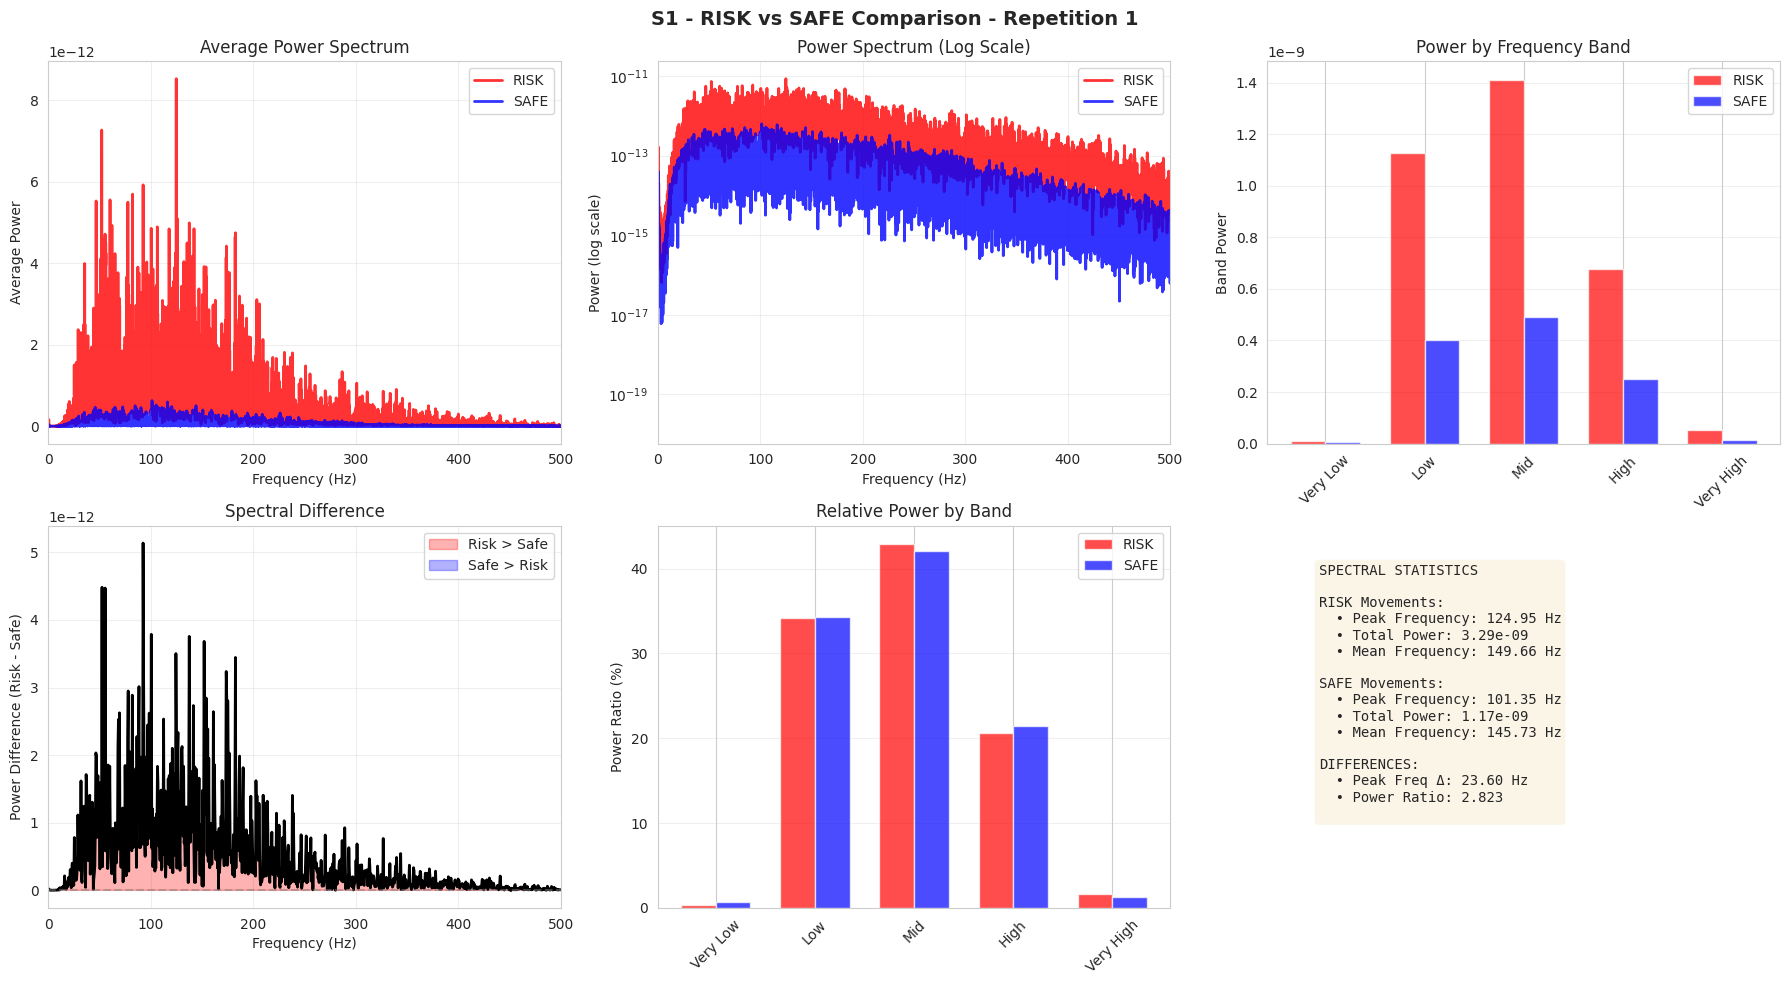

In [ ]:
# ============================================================================
# EJEMPLO 3: Comparación RISK vs SAFE
# ============================================================================

# Configuración
SUBJECT = 'S1'
REPETITION = 1  # Repetición a comparar (1-6)

fig = compare_risk_vs_safe_spectra(data_dict, SUBJECT, REPETITION, cfg)
plt.show()

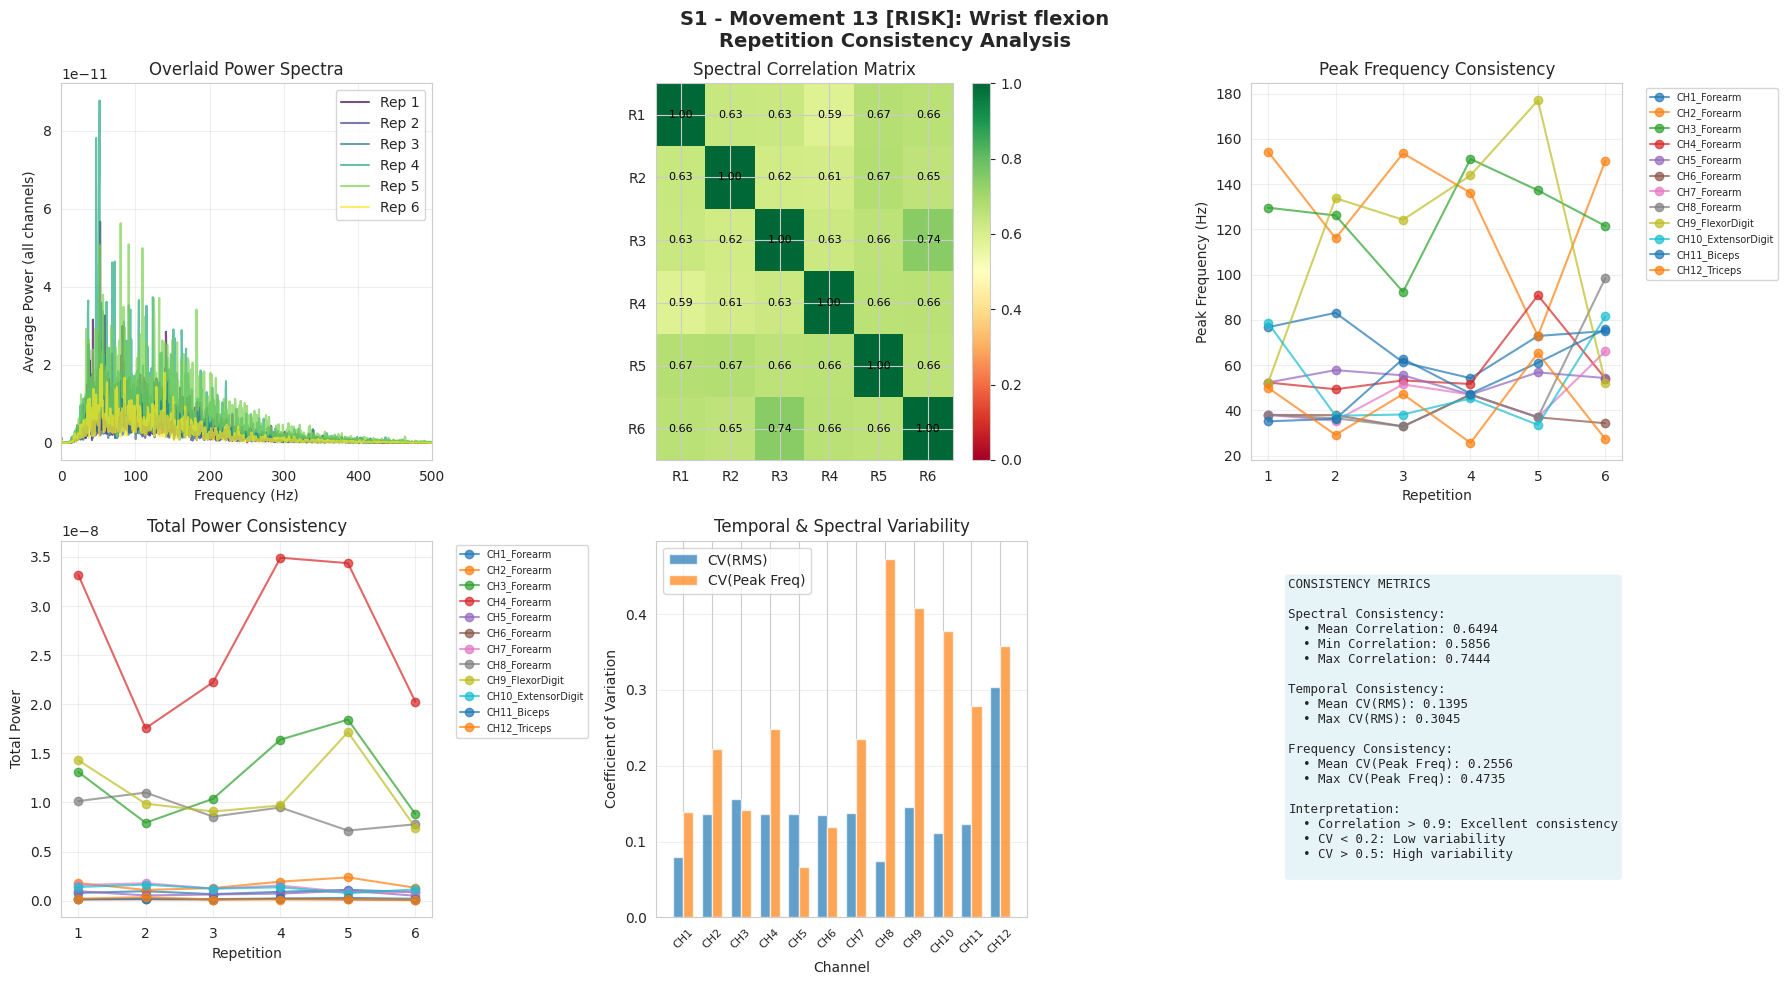

In [ ]:
# ============================================================================
# EJEMPLO 4: Análisis de consistencia entre repeticiones
# ============================================================================

# Configuración
SUBJECT = 'S1'
MOVEMENT = 13  # Movimiento a analizar (1-17)

fig = plot_repetition_consistency(data_dict, SUBJECT, MOVEMENT, cfg)
plt.show()


Analizando consistencia para S1...

  Risk Movement 13: Correlation = 0.6494
  Risk Movement 14: Correlation = 0.6472
  Risk Movement 15: Correlation = 0.6074
  Risk Movement 16: Correlation = 0.7446
  Safe Movement 1: Correlation = 0.7589
  Safe Movement 2: Correlation = 0.7685
  Safe Movement 3: Correlation = 0.7830
  Safe Movement 4: Correlation = 0.7630
  Safe Movement 5: Correlation = 0.7482
  Safe Movement 6: Correlation = 0.6806
  Safe Movement 7: Correlation = 0.8037
  Safe Movement 8: Correlation = 0.7087
  Safe Movement 9: Correlation = 0.6301
  Safe Movement 10: Correlation = 0.6859
  Safe Movement 11: Correlation = 0.7127
  Safe Movement 12: Correlation = 0.7648
  Safe Movement 17: Correlation = 0.7345

SUMMARY STATISTICS
RISK Movements:
  Mean Consistency: 0.6621 ± 0.0504
  Min: 0.6074
  Max: 0.7446

SAFE Movements:
  Mean Consistency: 0.7340 ± 0.0465
  Min: 0.6301
  Max: 0.8037

Difference:
  Δ Mean: 0.0719


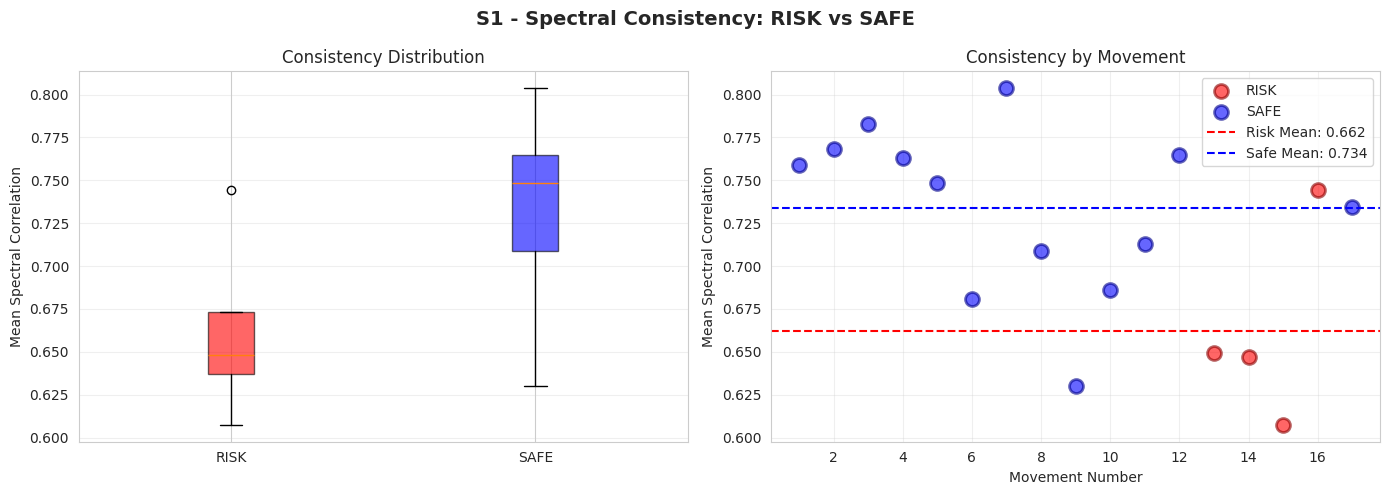

In [ ]:
# ============================================================================
# ANÁLISIS AVANZADO: Comparar consistencia RISK vs SAFE
# ============================================================================

def analyze_consistency_risk_vs_safe(data_dict, subject, cfg):
    """
    Compara la consistencia espectral entre movimientos Risk y Safe
    """
    risk_consistencies = []
    safe_consistencies = []

    print(f"\nAnalizando consistencia para {subject}...\n")

    # RISK movements
    for mov in cfg.RISK_MOVEMENTS:
        result = compute_repetition_consistency(data_dict, subject, mov, cfg)
        mean_corr = result['consistency']['mean_spectral_correlation']
        risk_consistencies.append(mean_corr)
        print(f"  Risk Movement {mov}: Correlation = {mean_corr:.4f}")

    # SAFE movements
    for mov in cfg.SAFE_MOVEMENTS:
        result = compute_repetition_consistency(data_dict, subject, mov, cfg)
        mean_corr = result['consistency']['mean_spectral_correlation']
        safe_consistencies.append(mean_corr)
        print(f"  Safe Movement {mov}: Correlation = {mean_corr:.4f}")

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    fig.suptitle(f'{subject} - Spectral Consistency: RISK vs SAFE', fontsize=14, fontweight='bold')

    # Box plot
    ax = axes[0]
    data_plot = [risk_consistencies, safe_consistencies]
    bp = ax.boxplot(data_plot, labels=['RISK', 'SAFE'], patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('blue')
    bp['boxes'][1].set_alpha(0.6)
    ax.set_ylabel('Mean Spectral Correlation')
    ax.set_title('Consistency Distribution')
    ax.grid(True, alpha=0.3, axis='y')

    # Scatter plot
    ax = axes[1]
    ax.scatter(cfg.RISK_MOVEMENTS, risk_consistencies, color='red', s=100,
               alpha=0.6, label='RISK', edgecolors='darkred', linewidths=2)
    ax.scatter(cfg.SAFE_MOVEMENTS, safe_consistencies, color='blue', s=100,
               alpha=0.6, label='SAFE', edgecolors='darkblue', linewidths=2)
    ax.axhline(np.mean(risk_consistencies), color='red', linestyle='--',
               label=f'Risk Mean: {np.mean(risk_consistencies):.3f}')
    ax.axhline(np.mean(safe_consistencies), color='blue', linestyle='--',
               label=f'Safe Mean: {np.mean(safe_consistencies):.3f}')
    ax.set_xlabel('Movement Number')
    ax.set_ylabel('Mean Spectral Correlation')
    ax.set_title('Consistency by Movement')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Estadísticas
    print(f"\n{'='*60}")
    print(f"SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"RISK Movements:")
    print(f"  Mean Consistency: {np.mean(risk_consistencies):.4f} ± {np.std(risk_consistencies):.4f}")
    print(f"  Min: {np.min(risk_consistencies):.4f}")
    print(f"  Max: {np.max(risk_consistencies):.4f}")
    print(f"\nSAFE Movements:")
    print(f"  Mean Consistency: {np.mean(safe_consistencies):.4f} ± {np.std(safe_consistencies):.4f}")
    print(f"  Min: {np.min(safe_consistencies):.4f}")
    print(f"  Max: {np.max(safe_consistencies):.4f}")
    print(f"\nDifference:")
    print(f"  Δ Mean: {abs(np.mean(risk_consistencies) - np.mean(safe_consistencies)):.4f}")

    return fig

# Ejecutar análisis
SUBJECT = 'S1'
fig = analyze_consistency_risk_vs_safe(data_dict, SUBJECT, cfg)
plt.show()

In [ ]:
# ============================================================================
# EXPORTAR RESULTADOS: Generar tabla de características espectrales
# ============================================================================

def export_spectral_features_table(data_dict, subject, cfg):
    """
    Genera tabla con características espectrales promedio por movimiento
    """
    results = []

    for movement in range(1, 18):
        result = compute_repetition_consistency(data_dict, subject, movement, cfg)

        # Promediar sobre repeticiones y canales
        reps = list(result['spectral_features'].keys())

        peak_freqs = []
        mean_freqs = []
        total_powers = []

        for rep in reps:
            features = result['spectral_features'][rep]['features']
            peak_freqs.append(np.mean(features['peak_frequency']))
            mean_freqs.append(np.mean(features['mean_frequency']))
            total_powers.append(np.mean(features['total_power']))

        category = 'RISK' if movement in cfg.RISK_MOVEMENTS else 'SAFE'

        results.append({
            'Subject': subject,
            'Movement': movement,
            'Category': category,
            'Movement_Name': cfg.MOVEMENT_NAMES.get(movement, ''),
            'Peak_Freq_Mean': np.mean(peak_freqs),
            'Peak_Freq_Std': np.std(peak_freqs),
            'Mean_Freq_Mean': np.mean(mean_freqs),
            'Mean_Freq_Std': np.std(mean_freqs),
            'Total_Power_Mean': np.mean(total_powers),
            'Total_Power_Std': np.std(total_powers),
            'Spectral_Consistency': result['consistency']['mean_spectral_correlation']
        })

    df = pd.DataFrame(results)
    return df

# Generar tabla para un sujeto
SUBJECT = 'S1'
df_features = export_spectral_features_table(data_dict, SUBJECT, cfg)

print(f"\n{'='*80}")
print(f"SPECTRAL FEATURES TABLE - {SUBJECT}")
print(f"{'='*80}")
print(df_features.to_string(index=False))

# Guardar a CSV (opcional)
# df_features.to_csv(f'spectral_features_{SUBJECT}.csv', index=False)
# print(f"\n✅ Tabla guardada: spectral_features_{SUBJECT}.csv")


SPECTRAL FEATURES TABLE - S1
Subject  Movement Category                                              Movement_Name  Peak_Freq_Mean  Peak_Freq_Std  Mean_Freq_Mean  Mean_Freq_Std  Total_Power_Mean  Total_Power_Std  Spectral_Consistency
     S1         1     SAFE                                                   Thumb up       54.491543       3.512564      116.604662       2.891998      2.925173e-10     6.444103e-11              0.758850
     S1         2     SAFE          Extension of index, middle, flexion of the others       74.016243       8.237603      112.427911       2.168395      6.598563e-10     1.494356e-10              0.768486
     S1         3     SAFE Flexion of ring and little finger, extension of the others       67.172614       6.057861      110.683093       1.505820      1.519044e-09     3.051151e-10              0.783012
     S1         4     SAFE                       Thumb opposing base of little finger       71.839291       7.083752      119.329675       3.891504   